In [236]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanketmishra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [237]:
#download data:
# !gdown 1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv --output ../../data/nlp/bbc-news.csv

In [238]:
#import libraries:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['figure.figsize'] = (10 , 10)
plt.rcParams['font.size'] = 15

In [239]:
df = pd.read_csv('../../data/nlp/bbc-news.csv' , sep='\t')
print(f"{df.shape}")
df.head()

(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [240]:
df = df[((~df['title'].isnull() & ~df['content'].isnull()))]
df.shape

(2225, 4)

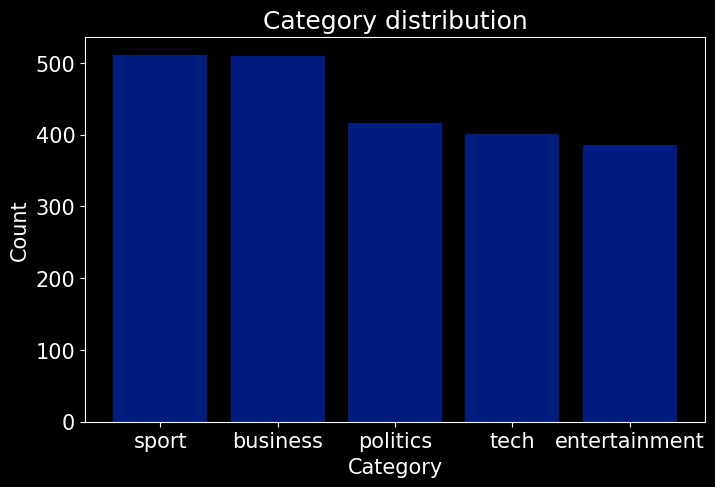

In [241]:
plt.figure(figsize = (8 , 5))
plt.bar(df.category.value_counts().index , df.category.value_counts().values)
plt.title('Category distribution')
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [242]:
i = 1807
print(f"Title: {df.title[i]}\nCategory: {df.category[i]}")

Title: Federer joins all-time greats
Category: sport


In [243]:
#import basic libraries and stuff:
import tensorflow as tf
from tensorflow import keras
import nltk
import string
import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanketmishra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [244]:
#text-cleaning:
def tclean(text):

    #lower the words in the text:
    text = text.lower()

    #replace fullstops with fullstops and space:
    text = text.replace('.' , '. ')

    #remove stop words:
    tokens = [word for word in text.split() if word not in stop_words]

    #remove punctuations:
    tokens = [token.translate(str.maketrans(' ', ' ' , string.punctuation)) for token in tokens]

    #join tokens back to form sentences:
    text = ' '.join(tokens)

    #remove extra space around text:
    text = text.strip()

    return text

In [245]:
for index , data in df.iterrows():
    df.loc[index , 'title'] = tclean(data['title'])

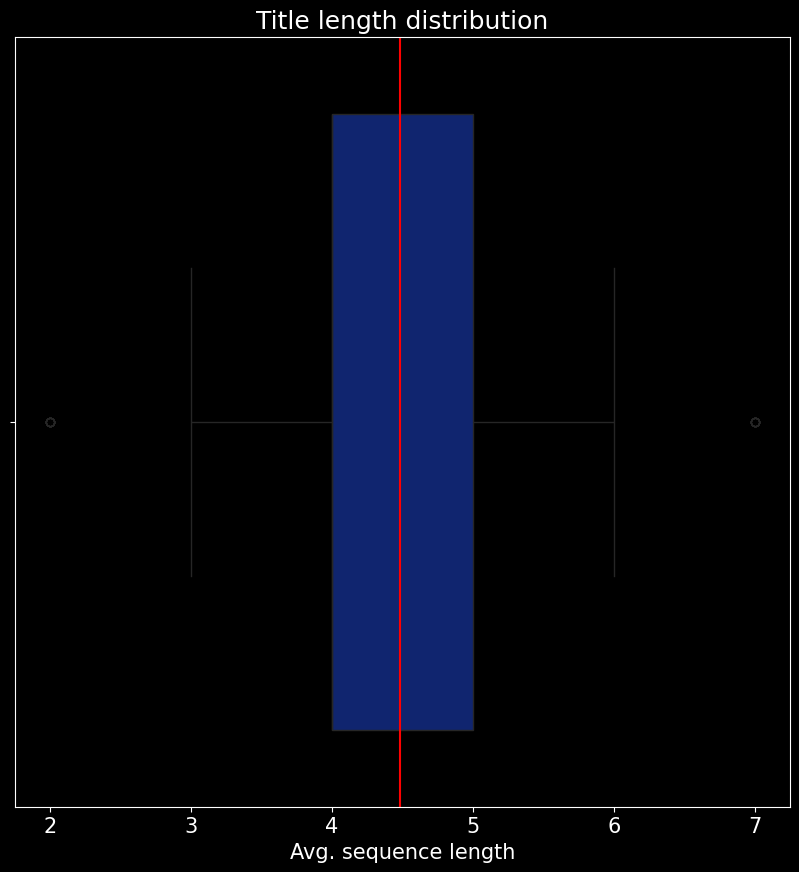

In [246]:
sns.boxplot(x = df['title'].str.split(' ').str.len())
plt.axvline(x = np.mean(df.title.str.split(' ').str.len()) , color = 'red')
plt.xlabel('Avg. sequence length')
plt.title('Title length distribution')
plt.show()

In [247]:
#max seq length and total # of classes:
maxlen = df.title.str.split(' ').str.len().max()
tclasses = df.category.nunique()
print(f"Max sequence length: {maxlen}")
print(f"Total classes: {tclasses}")

Max sequence length: 7
Total classes: 5


In [248]:
#split the data to train and test:
from sklearn.model_selection import train_test_split

xtrain , xtest , ytrain , ytest = train_test_split(df['title'] , df['category'] , test_size= 0.2 , random_state= 100)

xtrain = xtrain.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)

xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((1780,), (445,), (1780,), (445,))

In [249]:
#one-hot encode the labels:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output= False)
ytrain = ohe.fit_transform(ytrain.to_numpy().reshape(-1 , 1))
ytest = ohe.transform(ytest.to_numpy().reshape(-1 , 1))
ytrain.shape , ytest.shape

((1780, 5), (445, 5))

In [250]:
#tokenize and pad sequences:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def toknpad(text , mlen , tokenizer):
    tokens = tokenizer.texts_to_sequences(text)
    paddings = pad_sequences(tokens , maxlen = mlen , padding = 'post')

    return paddings

ttok = Tokenizer()
ttok.fit_on_texts(xtrain)

xtraine = toknpad(xtrain , maxlen , ttok)
xteste = toknpad(xtest , maxlen , ttok)
vocab = len(ttok.word_index)+ 1
print(f"Vocabulary size: {vocab}")

Vocabulary size: 3360


In [251]:
#define model:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
latent_dim = 50
embedding_dim = 100

seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential(name = 'first_rnn' , layers = [
    keras.Input(shape = (maxlen , ) , name = 'input_layer') , 
    layers.Embedding(vocab , embedding_dim , trainable = True , name = 'embedding_layer'),
    layers.SimpleRNN(latent_dim , recurrent_dropout= 0.2 , return_sequences= False , activation = 'tanh' , name = 'rnn_layer'),
    layers.Dense(tclasses , activation = 'softmax' , name = 'dense_layer')
])
model.summary()

Model: "first_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 7, 100)         │       336,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer (SimpleRNN)           │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,805 (1.31 MB)

 Trainable params: 343,805 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [252]:
#compile and train the model:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy', metrics = ['acc'])

estop = EarlyStopping(monitor = 'val_acc' , mode = 'max' , verbose = 1 , patience = 5)

model.fit(xtraine , ytrain , validation_data=(xteste , ytest) , batch_size= 64 , epochs = 10 , callbacks = [estop])
model.save('./models/rnn1.keras')

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2407 - loss: 1.5994 - val_acc: 0.2944 - val_loss: 1.5538
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5706 - loss: 1.3463 - val_acc: 0.5753 - val_loss: 1.2289
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7739 - loss: 0.8109 - val_acc: 0.6539 - val_loss: 0.9577
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9281 - loss: 0.3229 - val_acc: 0.6764 - val_loss: 0.9430
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9662 - loss: 0.1533 - val_acc: 0.6831 - val_loss: 1.0299
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9867 - loss: 0.0898 - val_acc: 0.6944 - val_loss: 1.1217
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9977 - loss: 0.0501 - val_acc: 0.6831 - val_loss: 1.2353
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9965 - loss: 0.0334 - val_acc: 0.6742 - val_loss: 1.3219
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9937 - loss: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6786516853932584


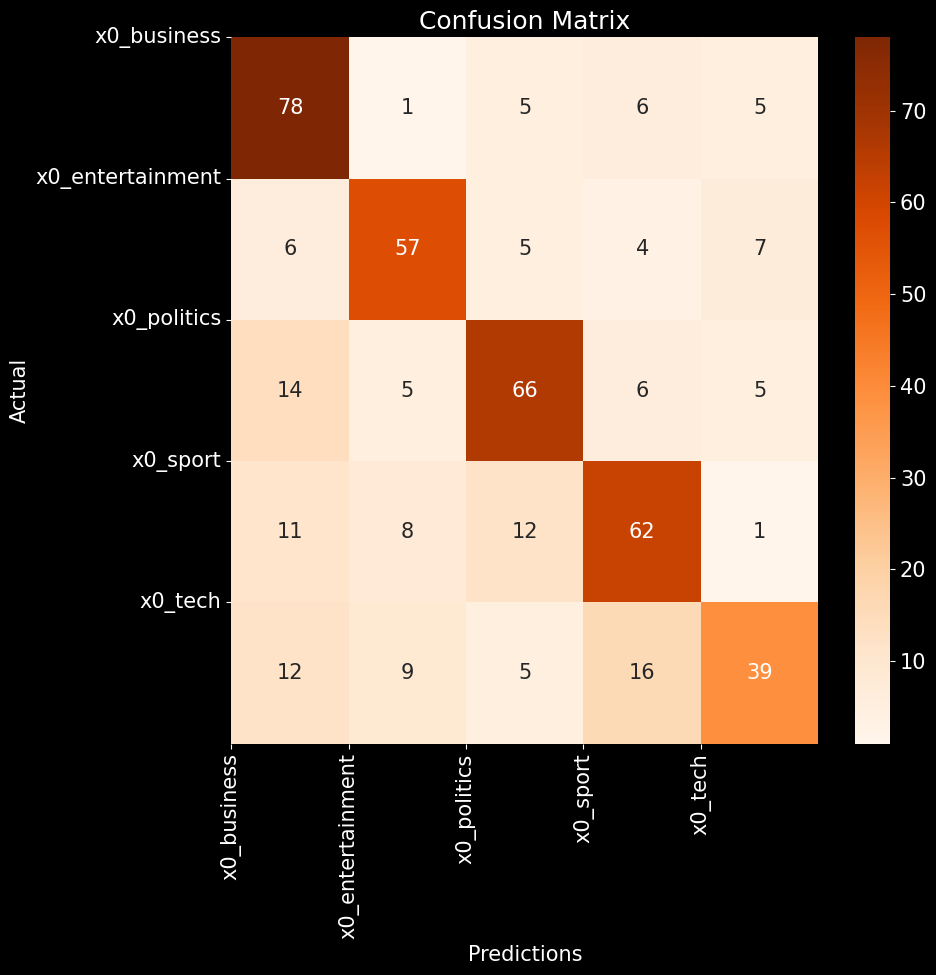

In [253]:
#load model and test
from sklearn.metrics import accuracy_score , confusion_matrix
rnn = tf.keras.models.load_model('./models/rnn1.keras')
preds = rnn.predict(xteste).argmax(axis = 1)
print(f"Accuracy: {accuracy_score(ytest.argmax(axis = 1) , preds)}")
cm = confusion_matrix(ytest.argmax(axis = 1) , preds)
sns.heatmap(cm , annot = True , cmap = 'Oranges')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
labels = ohe.get_feature_names_out()
plt.xticks(ticks = np.arange(len(labels)) , labels = labels , rotation = 90)
plt.yticks(ticks = np.arange(len(labels)) , labels = labels , rotation = 0)
plt.tight_layout()
plt.show()

In [254]:
ohe.get_feature_names_out()

array(['x0_business', 'x0_entertainment', 'x0_politics', 'x0_sport',
       'x0_tech'], dtype=object)

In [257]:
print(xtest[0] , xteste[0].shape)
xteste[0]

us woman sues ink cartridges (7,)


array([   1, 1336,  146, 2758,    0,    0,    0], dtype=int32)

In [306]:
text = 'business is good!'
# toknpad(xtest[0].reshape((1 , -1)) , maxlen , ttok)
texte = toknpad(pd.Series(text) , maxlen , ttok)
ohe.get_feature_names_out()[rnn.predict(texte).argmax(axis = 1)][0][3:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


'business'